In [6]:
from fourier import fourier
import math
import matplotlib.pyplot as plt

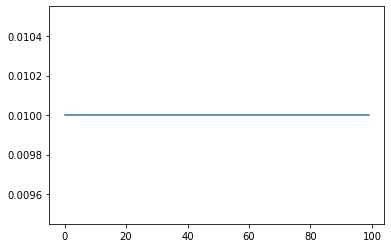

In [20]:
def g(n,x):
    if n==0:
        return math.cos(2*math.pi*x)
    elif n==1:
        if x<0.5:
            return 1
        else:
            return 0
    elif n==2:
        return math.e**(-9*x**2)
    elif n==3:
        return math.cos(8*math.pi*x)
    elif n==4:
        return int(x==0)
    else:
        return np.inf
d=100
n=4
theta = [ g(n,j/d) for j in range(d) ]
plt.plot(range(d),abs(fourier(theta)))

In [1]:
a=[1,2,3,4,5]

In [3]:
a[-2:-1]

[4]